In [2]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, LayerNormalization,
    MultiHeadAttention, Dropout,
    GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from pandas.tseries.offsets import DateOffset


In [3]:
datasets = joblib.load("all_pollutant_datasets.pkl")

In [4]:
def temporal_split(df):
    last_date = df["datetime"].max()
    test_start = last_date - DateOffset(months=6)
    val_start  = test_start - DateOffset(months=6)

    train = df[df["datetime"] < val_start]
    val   = df[(df["datetime"] >= val_start) & (df["datetime"] < test_start)]
    test  = df[df["datetime"] >= test_start]

    return train, val, test


In [5]:
BASE_FEATURES = [
    "lat", "lon",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "month", "is_weekend",
    "u", "v",
    "AT", "RH", "BP", "SolarRad", "Rain"
]


In [6]:
def get_feature_columns(df, target):
    lag_features = [
        c for c in df.columns
        if c.startswith(target + "_") or
           any(c.startswith(x + "_") for x in ["WS", "AT", "RH", "BP"])
    ]
    return BASE_FEATURES + lag_features


In [7]:
def scale_features(train, val, test, feature_cols):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train[feature_cols])
    X_val   = scaler.transform(val[feature_cols])
    X_test  = scaler.transform(test[feature_cols])
    return X_train, X_val, X_test, scaler


In [8]:
def create_sequences(X, y, timesteps=24):
    Xs, ys = [], []
    for i in range(timesteps, len(X)):
        Xs.append(X[i-timesteps:i])
        ys.append(y.iloc[i])
    return np.array(Xs), np.array(ys)


In [9]:
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2


Transformer Model (Optimized for SO₂)

In [10]:
def build_transformer(input_shape,
                      d_model=64,
                      num_heads=4,
                      ff_dim=128,
                      dropout=0.2):

    inputs = Input(shape=input_shape)

    x = Dense(d_model)(inputs)

    attn = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=d_model
    )(x, x)

    x = LayerNormalization()(x + attn)

    ffn = Dense(ff_dim, activation="relu")(x)
    ffn = Dense(d_model)(ffn)

    x = LayerNormalization()(x + ffn)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)

    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model


Train Transformer for SO₂ ONLY

In [14]:
target = "SO2"
print(f"\n===== Training Transformer for {target} =====")

df = datasets[target]
features = get_feature_columns(df, target)

train, val, test = temporal_split(df)

X_train, X_val, X_test, scaler = scale_features(train, val, test, features)
y_train, y_val, y_test = train[target], val[target], test[target]

X_train_seq, y_train_seq = create_sequences(X_train, y_train)
X_val_seq, y_val_seq     = create_sequences(X_val, y_val)
X_test_seq, y_test_seq   = create_sequences(X_test, y_test)

model = build_transformer(
    input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=60,
    batch_size=128,
    callbacks=[EarlyStopping(patience=8, restore_best_weights=True)],
    verbose=1
)



===== Training Transformer for SO2 =====
Epoch 1/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - loss: 11.3233 - mae: 1.5191 - val_loss: 0.8953 - val_mae: 0.7253
Epoch 2/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 10.0663 - mae: 1.3372 - val_loss: 0.8187 - val_mae: 0.6762
Epoch 3/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 9.8393 - mae: 1.2968 - val_loss: 0.7428 - val_mae: 0.6522
Epoch 4/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 9.7607 - mae: 1.2867 - val_loss: 0.8227 - val_mae: 0.6621
Epoch 5/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 9.6802 - mae: 1.2878 - val_loss: 0.6666 - val_mae: 0.6066
Epoch 6/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 9.4754 - mae: 1.2735 - val_loss: 0.8544 - val_mae: 0.7254
Epoch 7/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 9.3616 - mae: 1.2669 - val_loss: 1.5210 - val_mae: 1.0400
Epoch 8/60
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 9.6212 - mae: 1.3084 - val_loss: 1.0727 - val_mae: 0.8062
Ep

In [15]:
pred = model.predict(X_test_seq).ravel()
rmse, mae, r2 = evaluate(y_test_seq, pred)

print(f"\nSO2 Transformer → RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

SO2 Transformer → RMSE=0.690, MAE=0.548, R²=0.285


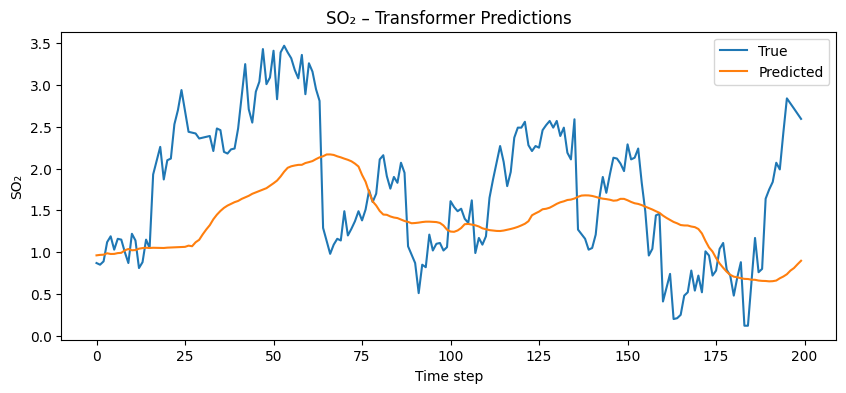

In [16]:
plt.figure(figsize=(10,4))
plt.plot(y_test_seq[:200], label="True")
plt.plot(pred[:200], label="Predicted")
plt.title("SO₂ – Transformer Predictions")
plt.xlabel("Time step")
plt.ylabel("SO₂")
plt.legend()
plt.show()
